In [71]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import ssl
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error



ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv("https://raw.githubusercontent.com/LyJacky/stocks/4802f4e0f139ee0568afbad309086d90c78a53b7/all_stocks_5yr.csv")


In [72]:
df1 = df.reset_index()['close']
# only for AAL stock
df1 = df1[0:1259]
df1

0       14.75
1       14.46
2       14.27
3       14.66
4       13.99
        ...  
1254    53.88
1255    52.10
1256    49.76
1257    51.18
1258    51.40
Name: close, Length: 1259, dtype: float64

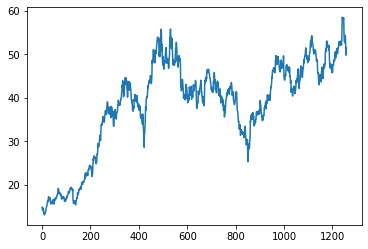

In [73]:
plt.plot(df1)

In [74]:
# scales the close values between the values 0 and 1
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.03806381],
       [0.03168317],
       [0.02750275],
       ...,
       [0.80836084],
       [0.83960396],
       [0.84444444]])

In [75]:
# training size is the number of data we are going to use for the traning data
training_size=int(len(df1)*0.65)
# test_size is just the complement of training size.
test_size=len(df1)-training_size
# makes 2 new lists train_data and test_data which are both subsets of the df1
# train_data is going to be df1 from 0 to training size, and tet_data will be from training size to the rest of the data
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [76]:

# 100 tie step means that the number of day entries
# every entry of dataX is going to have the past 100 days of the stock for all entries
# every entry of dataY is going to have the target price of that day
# returns numpy_array of the dataX and dataY since the library we are using only accepts those
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [77]:
# reshape into X=t,t+1,t+2..t+99 and Y=t+100
# time step is 100
time_step = 100

X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [78]:
X_train

array([[0.03806381, 0.03168317, 0.02750275, ..., 0.07480748, 0.08316832,
        0.0750275 ],
       [0.03168317, 0.02750275, 0.03608361, ..., 0.08316832, 0.0750275 ,
        0.08206821],
       [0.02750275, 0.03608361, 0.02134213, ..., 0.0750275 , 0.08206821,
        0.0840484 ],
       ...,
       [0.67392739, 0.68360836, 0.63960396, ..., 0.47678768, 0.47106711,
        0.47436744],
       [0.68360836, 0.63960396, 0.63256326, ..., 0.47106711, 0.47436744,
        0.44422442],
       [0.63960396, 0.63256326, 0.65071507, ..., 0.47436744, 0.44422442,
        0.43531353]])

In [79]:
# last one says one feature, reshapes features so its a 3 dim and the last dim is the number of features
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [81]:
# Building the LSTM model using keras
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)


Epoch 1/100
12/12 [==============================] - 11s 286ms/step - loss: 0.0895 - val_loss: 0.0197
Epoch 2/100
12/12 [==============================] - 2s 138ms/step - loss: 0.0134 - val_loss: 0.0035
Epoch 3/100
12/12 [==============================] - 3s 253ms/step - loss: 0.0075 - val_loss: 0.0161
Epoch 4/100
12/12 [==============================] - 3s 281ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 5/100
12/12 [==============================] - 2s 178ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 6/100
12/12 [==============================] - 2s 132ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 7/100
12/12 [==============================] - 1s 125ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 8/100
12/12 [==============================] - 1s 119ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 9/100
12/12 [==============================] - 1s 126ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 10/100
12/12 [==============================] - 2s 165ms/step - loss: 0.0030 - val_l

In [82]:
import tensorflow as tf


In [83]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 24ms/step


In [84]:
test_predict

array([[0.51437205],
       [0.5191533 ],
       [0.5313492 ],
       [0.54199743],
       [0.5488555 ],
       [0.5531531 ],
       [0.551089  ],
       [0.55509657],
       [0.5557333 ],
       [0.54784197],
       [0.5530819 ],
       [0.5593254 ],
       [0.56279945],
       [0.5698834 ],
       [0.586611  ],
       [0.601591  ],
       [0.60396016],
       [0.5986859 ],
       [0.5912202 ],
       [0.5829738 ],
       [0.582424  ],
       [0.5873186 ],
       [0.59725136],
       [0.59944206],
       [0.59629864],
       [0.5897338 ],
       [0.5872642 ],
       [0.60196304],
       [0.6208114 ],
       [0.63909787],
       [0.64846414],
       [0.6545856 ],
       [0.66048795],
       [0.67494583],
       [0.6842033 ],
       [0.6982643 ],
       [0.7123652 ],
       [0.71828926],
       [0.71783113],
       [0.7175338 ],
       [0.7222832 ],
       [0.7246219 ],
       [0.72877556],
       [0.72856194],
       [0.72082454],
       [0.7174387 ],
       [0.7149058 ],
       [0.720

In [85]:
#  tranforms the scaled values back to the original
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
# y_train=scaler.inverse_transform(y_train)
# ytest=scaler.inverse_transform(ytest)



In [86]:
ytest

array([0.5190319 , 0.5430143 , 0.54147415, 0.54675468, 0.55335534,
       0.54367437, 0.56919692, 0.5540154 , 0.5359736 , 0.57689769,
       0.56391639, 0.56237624, 0.57931793, 0.60748075, 0.60660066,
       0.59141914, 0.58987899, 0.58679868, 0.57865787, 0.59163916,
       0.59493949, 0.60682068, 0.58921892, 0.58723872, 0.579978  ,
       0.58789879, 0.62640264, 0.6310231 , 0.64664466, 0.64422442,
       0.65808581, 0.66842684, 0.69834983, 0.69152915, 0.72189219,
       0.73135314, 0.72739274, 0.72739274, 0.73311331, 0.74367437,
       0.73663366, 0.74521452, 0.73531353, 0.72013201, 0.72783278,
       0.71947195, 0.73509351, 0.78393839, 0.77073707, 0.80572057,
       0.76061606, 0.76611661, 0.76787679, 0.77623762, 0.76149615,
       0.78239824, 0.79647965, 0.8019802 , 0.78481848, 0.78019802,
       0.78305831, 0.76237624, 0.75313531, 0.74081408, 0.73223322,
       0.7410341 , 0.72321232, 0.73025303, 0.74939494, 0.78019802,
       0.78371837, 0.77183718, 0.76193619, 0.74213421, 0.76171

In [99]:
# changes the y_train and ytest values back to the original values, I had to transpose [y_train] and [x_train] so it
# would be the same dimensions as the test_predict and train_predict
y_train=scaler.inverse_transform(np.transpose([y_train]))
ytest=scaler.inverse_transform(np.transpose([ytest]))

In [105]:
print(ytest.shape)
print(test_predict.shape)

(340, 1)
(340, 1)


In [100]:
math.sqrt(mean_squared_error(y_train,train_predict))

1.1382230188186746

In [101]:
math.sqrt(mean_squared_error(ytest,test_predict))


1.1799393238929605

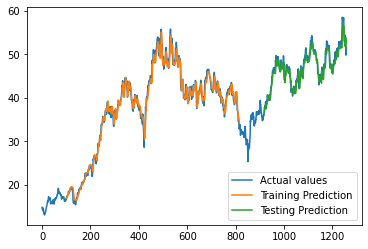

In [108]:

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df1),label = "Actual values")
plt.plot(trainPredictPlot,label = "Training Prediction")
plt.plot(testPredictPlot, label = "Testing Prediction")
plt.legend()
plt.show()
